## import

In [1]:
import time
import pandas as pd
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

%config InlineBackend.figure_format = 'retina'                                    # so you can see plots in HD :) 
#colors = sns.color_palette("colorblind").as_hex()
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
NSIDE = 2048                                                                      # given in the name of the maps

## extract CMB maps and masks

In [2]:
def extract_data(filepath, hdu=1):
    '''
    Extracts input HDU from map Planck FITS file (we only need the first one)
    Document function once fully tested
    '''
    
    hdul = fits.open(filepath)
    data = hdul[hdu].data                    # hdul is a list of HDU objects

    hdul.info()                              # prints metadata about FITS file (HDUs)
    print('='*90)
    hdul.close()                    
    
    return data

# Define each filepath
filenames = ['HFI_SkyMap_143_2048_R3.01_halfmission-1.fits',        # map for half mission 1 143 GHZ
             'HFI_SkyMap_143_2048_R3.01_halfmission-2.fits',        # map for half mission 2 143 GHZ
             'HFI_Mask_GalPlane-apo5_2048_R2.00.fits',              # galactic plane mask for APO..
             'HFI_Mask_PointSrc_2048_R2.00.fits',                   # mask point source
             'Bl_T_R3.01_fullsky_143hm1x143hm1.fits',               # beam transfer function for hm1
             'Bl_T_R3.01_fullsky_143hm1x143hm2.fits',               # beam transfer function for hm2
            ]

start1 = time.time()
# extract data
datalist = []
for filename in filenames:
    data_i = extract_data('data/'+filename)
    datalist.append(data_i)
end1 = time.time()
print(f'It took {end1-start1:.2f}s. to extract the Planck data files.')

sky_hm1, sky_hm2, mask_gp, mask_ps = datalist[:4]
beamf_hm1, beamf_hm2 = datalist[4:]

Filename: data/HFI_SkyMap_143_2048_R3.01_halfmission-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  FREQ-MAP      1 BinTableHDU     75   50331648R x 10C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E']   
Filename: data/HFI_SkyMap_143_2048_R3.01_halfmission-2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  FREQ-MAP      1 BinTableHDU     75   50331648R x 10C   ['E', 'E', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E']   
Filename: data/HFI_Mask_GalPlane-apo5_2048_R2.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GAL-MASK      1 BinTableHDU     54   50331648R x 8C   ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']   
Filename: data/HFI_Mask_PointSrc_2048_R2.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   () 

## visualize data

In [ ]:
#hp.mollview(
#    data_map_hm1,
#    coord=["G", "E"],
#    title="Histogram equalized Ecliptic",
#    unit="mK",
#    norm="hist",
#    min=-1,
#    max=1,
#)
#hp.graticule()

## compute spherical harmoncis

In [ ]:
def find_spherical_harmonics(map_table, gp_table, ps_table, apply_mask=True,
                             stoke_param ='I_STOKES', galactic_plane='GAL040', 
                             frequency=143, NSIDE=2048):
    '''
    Computes the spherical harmonics from a map,
    masking the stokes parameters from the raw CMB data
    Fully document function once fully tested
    '''
    
    start = time.time()
    
    # extract stoke parameter (T or I by default) and mask based on galactic plane and point source
    x = map_table[stoke_param]
    
    if apply_mask:
        gp_mask = gp_table[galactic_plane]
        ps_mask = ps_table[f'F{frequency}']
        x_masked = x*gp_mask*ps_mask
    else:
        x_masked = x
    
    # compute spherical harmonics
    a_lm =  hp.sphtfunc.map2alm(x_masked, lmax=4000)               # lmax=4000 is a good estimate, default is #*NSIDE-1
    
    end = time.time()
    print(f'It took {end-start:.2f} s. to compute a_lm')
    
    return a_lm

# Call function
#a_lm_1 = find_spherical_harmonics(sky_hm1, mask_gp, mask_ps)
#a_lm_2 = find_spherical_harmonics(sky_hm2, mask_gp, mask_ps)

In [ ]:
a_lm_2 = find_spherical_harmonics(sky_hm2, mask_gp, mask_ps)

In [3]:
# check whether the map has any undefined pixels
hm1, hm2 = sky_hm1['I_STOKES'], sky_hm2['I_STOKES']
#undef_hm1, undef_hm2 = np.where(~np.isfinite(hm1)), np.where(~np.isfinite(hm2)) 

#print(undef_hm1)
#print(undef_hm2)

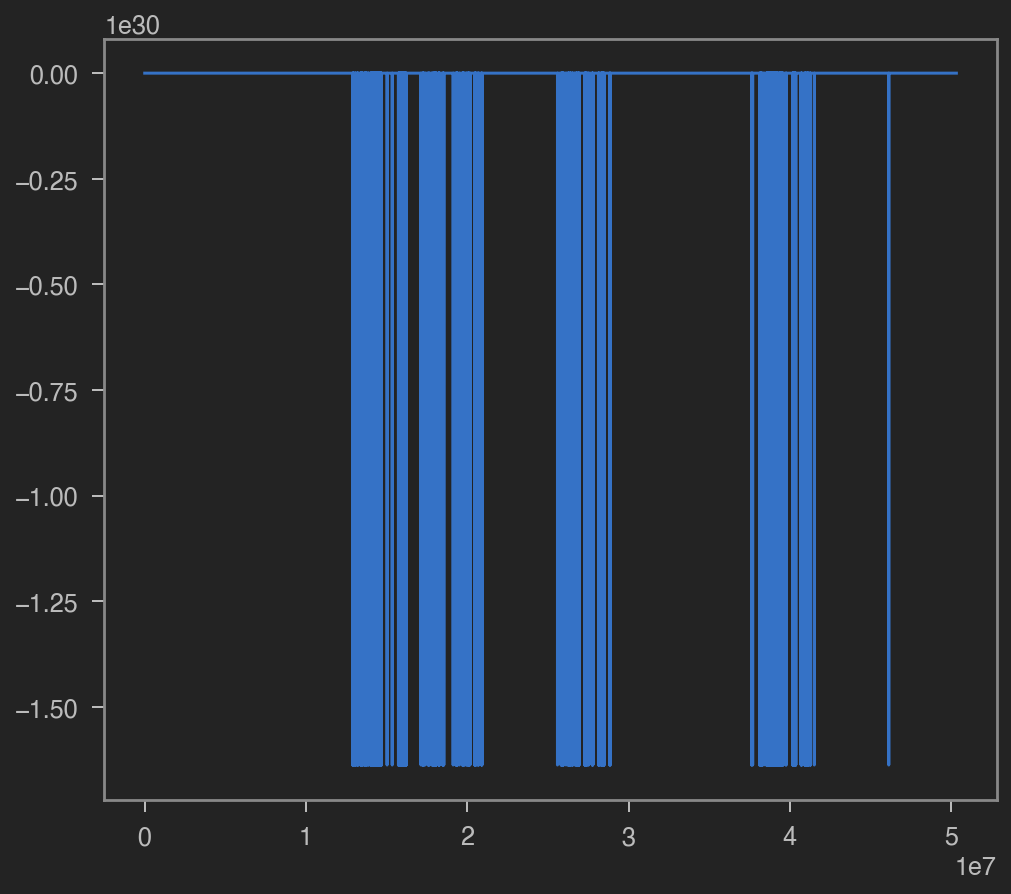

In [5]:
plt.figure()
plt.plot(hm2)

## compute actual cross power spectrum

In [ ]:
def find_power_spectrum(alm_1, alm_2,
                        M_ll, b_l, f_l=1, n_l=0, NSIDE=2048):
    '''
    Finds the cross-power spectrum (via pseudo cross power spectrum) given the 
    coefficients of the spherical harmonics
    Document function once fully tested
    '''
    # compute pseudo power spectrum
    D_l = alm2cl(alm_1, alm_2)
    
    # now define all the instrument related biases
    p_l = hp.sphtfunc.pixwin(NSIDE)
    m_ll = #? 
    b_l = #??

In [ ]:
hp.__version__